## Συναρτησεις

In [ ]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import pandas as pd
import os
from torch.optim import lr_scheduler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from pathlib import Path
from sklearn.model_selection import KFold
import plotly.graph_objects as go
import pickle
from itertools import permutations
import random

BATCH_SIZE = 32
NUM_ANTENNAS = 2
random.seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device, imports complete!'.format(device))

Using cuda device, imports complete!


In [3]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    model.to(device)
    model.train()

    train_loss = 0
    for X_batch, y_batch in data_loader:
        # Send data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        train_loss += loss.item()
    
    return train_loss

In [4]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    model.to(device)
    model.eval()

    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in data_loader:
            # Send data to GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            test_loss += loss_fn(y_test_pred, y_batch).item()
    
    return test_loss

In [5]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, verbose=False, path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path

        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            if self.verbose:
                print(f"Validation loss decreased to {val_loss:.6f}. Saving model...")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
    
    def get_best_loss(self):
        return self.best_loss

In [6]:
def train_test_model(epoch: int, 
                     model: torch.nn.Module,
                     train_loader: torch.utils.data.DataLoader,
                     test_loader: torch.utils.data.DataLoader,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     scheduler,
                     early_stopper = None,
                     device: torch.device = 'cpu',
                     test: bool = True,
                     verbose: bool = True):

    torch.manual_seed(42)
    train_loss_arr = []
    test_loss_arr = []
    
    if(test):
        for epochs in range(epoch):
            # Train for one epoch
            epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
            train_loss_arr.append(epoch_loss / len(train_loader))

            # Scheduler update
            scheduler.step(epoch_loss)
            after_lr = optimizer.param_groups[0]['lr']

            # Evaluate on test set
            test_loss = test_step(model, test_loader, loss_fn, device)
            test_loss_arr.append(test_loss / len(test_loader))

            # Print progress
            if verbose == True:
                if (epochs % 10 == 0) or (epochs == 0):
                    print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]:.6f} | Loss test: {test_loss_arr[-1]:.6f} | lr = {after_lr}')
                elif epochs + 1 == epoch:
                    print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]:.6f} | Loss test: {test_loss_arr[-1]:.6f} | lr = {after_lr}')

            # Early stopping check
            early_stopper(test_loss_arr[-1], model)
            if early_stopper.early_stop:
                if verbose == True:
                    print(f"Early stopping at epoch {epochs}")
                break

        # Load the best model weights after stopping
        if early_stopper.path is not None:
            model.load_state_dict(torch.load(early_stopper.path, weights_only= True))
            if verbose == True:
                print(f"Loaded best model from {early_stopper.path}")

        return train_loss_arr, test_loss_arr, early_stopper.get_best_loss(), epochs
    else:
        for epochs in range(epoch):
            # Train for one epoch
            epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
            train_loss_arr.append(epoch_loss / len(train_loader))

            # Scheduler update
            scheduler.step(epoch_loss)
            after_lr = optimizer.param_groups[0]['lr']

            # Print progress
            if verbose == True:
                if (epochs % 10 == 0) or (epochs == 0):
                    print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]:.6f} | lr = {after_lr}')
                elif epochs + 1 == epoch:
                    print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]:.6f} | lr = {after_lr}')
        return train_loss_arr

In [7]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def eval_model_3d_interactive(model: torch.nn.Module, 
                                         data_loader: torch.utils.data.DataLoader, 
                                         scaler,
                                         device: torch.device = 'cpu',
                                         verbose=True):

    model.eval()
    model.to(device)
    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            # Move to CPU and collect all predictions and targets
            all_preds.append(y_pred.cpu())
            all_targets.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Reverse scaling
    y_pred_real = scaler.inverse_transform(all_preds) * 100
    y_true_real = scaler.inverse_transform(all_targets) * 100

    # Calculate average Euclidean distance (in cm)
    distances = np.linalg.norm(y_pred_real - y_true_real, axis=1)
    mean_distance_error = np.mean(distances)
    std_distance_error = np.std(distances)

    # Plot real data VS predicted in 3D
    if verbose:
        number_of_points = 20

        # Interactive Plot with Plotly
        trace_gt = go.Scatter3d(
            x=y_true_real[:number_of_points, 0],
            y=y_true_real[:number_of_points, 1],
            z=y_true_real[:number_of_points, 2],
            mode='markers',
            marker=dict(size=5, color='blue'),
            name='Ground Truth'
        )

        trace_pred = go.Scatter3d(
            x=y_pred_real[:number_of_points, 0],
            y=y_pred_real[:number_of_points, 1],
            z=y_pred_real[:number_of_points, 2],
            mode='markers',
            marker=dict(size=5, color='red'),
            name='Predicted'
        )

        lines = []
        for i, (gt, pred) in enumerate(zip(y_true_real[:number_of_points], y_pred_real[:number_of_points])):
            lines.append(go.Scatter3d(
                x=[gt[0], pred[0]],
                y=[gt[1], pred[1]],
                z=[gt[2], pred[2]],
                mode='lines',
                line=dict(color='gray', width=1),
                showlegend=False
            ))

        # Combine all traces
        fig_plotly = go.Figure(data=[trace_gt, trace_pred] + lines)

        # Set layout
        fig_plotly.update_layout(
            title=f'Interactive Plot<br>Mean Distance Error: {mean_distance_error:.2f} cm, Std: {std_distance_error:.2f} cm',
            scene=dict(
                xaxis_title='X',
                yaxis_title='Y',
                zaxis_title='Z',
            ),
            legend=dict(x=0, y=1),
        )

        # Show the interactive plot
        #fig_plotly.show()

        # Static Plot with Matplotlib
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111, projection='3d')

        # Plot ground truth points
        ax.scatter(
            y_true_real[:number_of_points, 0], 
            y_true_real[:number_of_points, 1], 
            y_true_real[:number_of_points, 2], 
            color='blue', label='Ground Truth', s=50
        )

        # Plot predicted points
        ax.scatter(
            y_pred_real[:number_of_points, 0], 
            y_pred_real[:number_of_points, 1], 
            y_pred_real[:number_of_points, 2], 
            color='red', label='Predicted', s=50
        )

        # Draw lines connecting corresponding points
        for i, (gt, pred) in enumerate(zip(y_true_real[:number_of_points], y_pred_real[:number_of_points])):
            ax.plot(
                [gt[0], pred[0]], 
                [gt[1], pred[1]], 
                [gt[2], pred[2]], 
                color='gray', linestyle='--', linewidth=1
            )
            
            # Calculate the midpoint of the line for placing the text
            mid_x = (gt[0] + pred[0]) / 2
            mid_y = (gt[1] + pred[1]) / 2
            mid_z = (gt[2] + pred[2]) / 2
            
            # Annotate the line with the corresponding distance from the distances array
            ax.text(mid_x, mid_y, mid_z, f'{distances[i]:.2f} cm', fontsize=9, ha='center', va='bottom', color='black',
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.3))
        # Add labels and legend
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Static Plot\nMean Distance Error: {mean_distance_error:.2f} cm, Std: {std_distance_error:.2f} cm')
        ax.legend()

        # Show the static plot
        plt.show()

    return {
        "model_name": model.__class__.__name__,
        "mean_distance_error_cm": mean_distance_error.item(),
        "std": std_distance_error.item(),
        "distances": distances
    }

In [8]:
def plot_results(train_arr, test_arr):
    # Plot the loss curves
    train_arr = (train_arr - np.min(train_arr)) / (np.max(train_arr) - np.min(train_arr))
    test_arr = (test_arr - np.min(test_arr)) / (np.max(test_arr) - np.min(test_arr))
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_arr, label='Train Loss')
    plt.plot(test_arr, label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.title("Normalized Training Loss")
    plt.grid()
    plt.legend()
    plt.show()

### Data Funcs

In [16]:
def data_func_cv(X_train_raw,y_train, X_test_raw, y_test, batch_size=32):
    # Compute abs max PER FEATURE on training data
    for i in range(len(X_train_raw)):
        for j in range(X_train_raw.shape[2]):
            if (j+1)%4 == 0:
                X_train_raw[i, :,j] -= np.min(X_train_raw[i,:,j])        

    for i in range(len(X_test_raw)):
        for j in range(X_test_raw.shape[2]):
            if (j+1)%4 == 0:
                X_test_raw[i, :,j] -= np.min(X_test_raw[i,:,j]) 

    abs_max = np.abs(X_train_raw).max(axis=(0,1))  # max per feature over (samples, time)
    for j in range(X_train_raw.shape[2]):
        if (j+1)%4 == 0:
            abs_max[j-2] = abs_max[j-3]

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_train_raw / abs_max  
    X_test_norm = X_test_raw / abs_max  

    # Now reshape for linear model
    X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  
    X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)   

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train)
    y_test_scaled = scaler_Y.transform(y_test)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    g = torch.Generator()
    g.manual_seed(42)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, generator= g)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)


    return train_loader, test_loader, scaler_Y


In [15]:
def data_func_eval(X_main, X_holdout, y_main, y_holdout, batch_size = 32):
    # Compute abs max PER FEATURE on training data

    for i in range(len(X_main)):
        for j in range(X_main.shape[2]):
            if (j+1)%4 == 0:
                X_main[i, :,j] -= np.min(X_main[i,:,j])        

    for i in range(len(X_holdout)):
        for j in range(X_holdout.shape[2]):
            if (j+1)%4 == 0:
                X_holdout[i, :,j] -= np.min(X_holdout[i,:,j])      
    abs_max = np.abs(X_main).max(axis=(0,1))  # max per feature over (samples, time)
    for j in range(X_main.shape[2]):
        if (j+1)%4 == 0:
            abs_max[j-2] = abs_max[j-3]

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_main / abs_max  # shape (N_train, 500, 4)
    X_test_norm = X_holdout / abs_max    # shape (N_test, 500, 4)

    # Now reshape for linear model
    X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  # (N_train, 2000)
    X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)     # (N_test, 2000)

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_main_scaled = scaler_Y.fit_transform(y_main)
    y_holdout_scaled = scaler_Y.transform(y_holdout)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_main_tensor = torch.tensor(y_main_scaled, dtype=torch.float32)
    y_holdout_tensor = torch.tensor(y_holdout_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_main_tensor)
    test_data = TensorDataset(X_test_tensor, y_holdout_tensor)

    g = torch.Generator()
    g.manual_seed(42)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, generator= g)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

### CV

In [ ]:
def cross_validation_dat(Main_Data,Holdout_Data, n_splits, model, model_param, loss_fn, optimizer_1, optimizer_param, scheduler_param, early_stopper_param, epochs, device, verbose = True, n_antennas = 2):

    # Initialize KFold
    kf = KFold(n_splits= n_splits, shuffle= True, random_state= 42)

    # Initialize arrays to store losses and epochs
    cv_losses = []
    epoch_array = []
    # Loop over the folds to perform cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(range(len(Main_Data)))):
        
        print(f"Fold {fold_idx + 1}")

        train = [Main_Data[i] for i in train_idx]
        test = [Main_Data[i] for i in val_idx]
        
        all_permutations_train = []
        for sublist in train:
            sublist_permutations = list(permutations(sublist,n_antennas))
            if n_antennas ==4:
                all_permutations_train.append([sublist_permutations[0]])
            else:
                all_permutations_train.append(sublist_permutations)

        train_data = []
        train_labels = []
        for perms in all_permutations_train:
            for perm in perms:
                connected_paths = []
                for i in range(len(perm)):
                    connected_paths.append(perm[i]['path'])
                if(connected_paths!=[]):
                    paths = np.hstack(connected_paths)
                    train_data.append(paths)
                    train_labels.append(perm[0]['tag_pos'])

        train_data = np.array(train_data)
        train_labels = np.array(train_labels)
        all_permutations_test = []
        for sublist in test:
            sublist_permutations = list(permutations(sublist,n_antennas))
            if n_antennas==4:
                all_permutations_test.append([sublist_permutations[0]])
            else:
                all_permutations_test.append(sublist_permutations)
        
        test_data = []
        test_labels = []
        for perms in all_permutations_test:
            for perm in perms:
                connected_paths = []
                for i in range(len(perm)):
                    connected_paths.append(perm[i]['path'])
                if(connected_paths!=[]):
                    paths = np.hstack(connected_paths)
                    test_data.append(paths)
                    test_labels.append(perm[0]['tag_pos'])

        test_data = np.array(test_data)
        test_labels = np.array(test_labels)

        train_loader, test_loader, _ = data_func_cv(train_data, train_labels, test_data, test_labels, batch_size=BATCH_SIZE)
        # Instantiate the model
        model_0 = model(**model_param)

        loss_fn = loss_fn
        optimizer = optimizer_1(model_0.parameters(), **optimizer_param)

        # Initialize the scheduler
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_param)

        # Initialize early stopping
        early_stopper = EarlyStopping(**early_stopper_param)

        # Load the data
        arr1, arr2, best_loss, epoch_stop = train_test_model(epoch = epochs,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True, verbose = verbose)
        
        if verbose == True:
            plot_results(arr1, arr2)

        cv_losses.append(best_loss)
        epoch_array.append(epoch_stop)
    
    all_permutations_main = []
    for sublist in Main_Data:
        sublist_permutations = list(permutations(sublist,n_antennas))
        if n_antennas ==4:
            all_permutations_main.append([sublist_permutations[0]])
        else:
            all_permutations_main.append(sublist_permutations)
    
    main_data = []
    main_labels = []
    for perms in all_permutations_main:
        for perm in perms:
            connected_paths = []
            for i in range(len(perm)):
                connected_paths.append(perm[i]['path'])
            if(connected_paths!=[]):
                paths = np.hstack(connected_paths)
                main_data.append(paths)
                main_labels.append(perm[0]['tag_pos'])

    main_data = np.array(main_data)
    main_labels = np.array(main_labels)

    all_permutations_holdout = []
    for sublist in Holdout_Data:
        sublist_permutations = list(permutations(sublist,n_antennas))
        if n_antennas ==4:
            all_permutations_holdout.append([sublist_permutations[0]])
        else:
            all_permutations_holdout.append(sublist_permutations)
    
    holdout_data = []
    holdout_labels = []
    for perms in all_permutations_holdout:
        for perm in perms:
            connected_paths = []
            for i in range(len(perm)):
                connected_paths.append(perm[i]['path'])
            if(connected_paths!=[]):
                paths = np.hstack(connected_paths)
                holdout_data.append(paths)
                holdout_labels.append(perm[0]['tag_pos'])
    
    holdout_data = np.array(holdout_data)
    holdout_labels = np.array(holdout_labels)
    
    # Evaluate the final model
    train_loader, test_loader, scaler_Y = data_func_eval(main_data, holdout_data, main_labels, holdout_labels, batch_size=BATCH_SIZE)
    print(f"Cross-Validation finished with mean error across {n_splits} subsets = {np.mean(cv_losses)}, evaluating final model...")

    # Instantiate the model
    final_model = model(**model_param)

    final_optimizer = optimizer_1(final_model.parameters(), **optimizer_param)

    # Initialize the scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(final_optimizer, **scheduler_param)

    # Load the data
    arr1= train_test_model(epoch = np.max(epoch_array),model = final_model, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=final_optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= False, verbose= verbose)

    result = eval_model_3d_interactive(model= final_model, data_loader= test_loader, scaler= scaler_Y, verbose= True)
    return result

***

# Εισαγωγη δεδομενων

In [19]:
# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()


parent_dir = os.path.join(parent_dir, '..','..', 'Simulation') 

data_dir = os.path.join(parent_dir,'Sim_Data_3D_4500.pkl')
with open(data_dir,'rb') as f:
    experiment_data = pickle.load(f)

random.seed(42)
random.shuffle(experiment_data)

In [20]:
experiment_data[:2]

[[{'Antenna': 1,
   'path': array([[  1.44017767,   0.        ,   0.633     , -25.22853438],
          [  1.44415929,   0.        ,   0.633     , -25.50675366],
          [  1.44814092,   0.        ,   0.633     , -25.39533039],
          ...,
          [  2.96115949,   0.        ,   0.633     ,  -8.483935  ],
          [  2.96514111,   0.        ,   0.633     ,  -8.42404515],
          [  2.96912274,   0.        ,   0.633     ,  -8.30934647]],
         shape=(385, 4)),
   'tag_name': 3554,
   'tag_pos': [np.float64(1.3648877107170383),
    np.float64(2.4),
    np.float64(1.410344827586207)]},
  {'Antenna': 2,
   'path': array([[  0.77545061,   0.        ,   1.073     , -23.43257345],
          [  0.77947901,   0.        ,   1.073     , -23.47935372],
          [  0.7835074 ,   0.        ,   1.073     , -23.54704194],
          ...,
          [  2.31429702,   0.        ,   1.073     , -19.60067454],
          [  2.31832541,   0.        ,   1.073     , -19.55217905],
          [  2.3223

In [21]:
print(len(experiment_data))

main_data = experiment_data[:int(0.9*len(experiment_data))]
holdout_data = experiment_data[int(0.9*len(experiment_data)):]

4500


In [ ]:
output_len = len(experiment_data[0][0]['tag_pos'])

trial_arr = np.array(experiment_data[0][0]['path'])

input_len = trial_arr.shape[0] * trial_arr.shape[1] *NUM_ANTENNAS # 2 since we are dealing with double antenna, len(experiment_data[0] could be 2,3 or 4 depending on the shuffle)

input_len,output_len

(3080, 3)

# εικονες

In [ ]:
all_permutations_train = []
for sublist in main_data:
    #an xalasan ola, tote NUM_ANTENNAS = 2 gia num !=2 mporei crash
    sublist_permutations = list(permutations(sublist,NUM_ANTENNAS))
    if 2 ==4:
        all_permutations_train.append([sublist_permutations[0]])
    else:
        all_permutations_train.append(sublist_permutations)

train_data = []
train_labels = []
for perms in all_permutations_train:
    for perm in perms:
        connected_paths = []
        for i in range(len(perm)):
            connected_paths.append(perm[i]['path'])
        if(connected_paths!=[]):
            paths = np.hstack(connected_paths)
            train_data.append(paths)
            train_labels.append(perm[0]['tag_pos'])

train_data = np.array(train_data)
train_labels = np.array(train_labels)

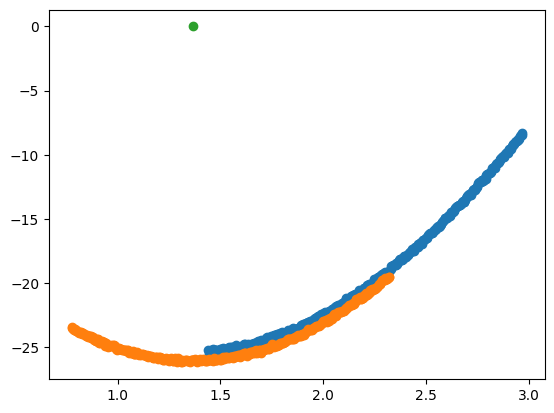

In [41]:
sample = 0 
plt.scatter(train_data[sample,:,0], train_data[sample, :,3])
plt.scatter(train_data[sample,:,4], train_data[sample, :,7])
plt.scatter(train_labels[sample,0], 0)

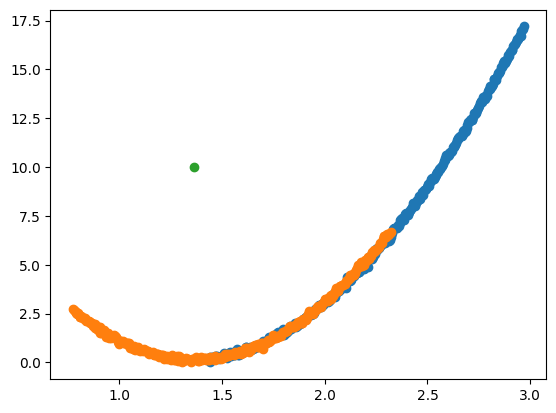

In [43]:
for i in range(len(train_data)):
    for j in range(train_data.shape[2]):
        if (j+1)%4 == 0:
            train_data[i, :,j] -= np.min(train_data[i,:,j])

sample = 0 
plt.scatter(train_data[sample,:,0], train_data[sample, :,3])
plt.scatter(train_data[sample,:,4], train_data[sample, :,7])
plt.scatter(train_labels[sample,0], 10)

In [49]:
abs_max = np.abs(train_data).max(axis=(0,1))  # max per feature over (samples, time)
for j in range(train_data.shape[2]):
    if (j+1)%4 == 0:
        print(abs_max[j-2], abs_max[j-3])
        abs_max[j-2] = abs_max[j-3]

# Prevent division by zero
abs_max[abs_max == 0] = 1.0

# Normalize per feature
X_train_norm = train_data / abs_max 

0.0 3.9738534319760372
0.0 3.9738534319760372


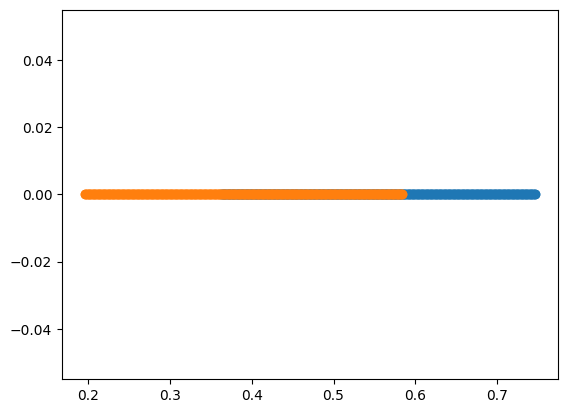

In [50]:
sample = 0 
plt.scatter(X_train_norm[sample,:,0], X_train_norm[sample, :,1])
plt.scatter(X_train_norm[sample,:,4], X_train_norm[sample, :,5])


***

# Αρχιτεκτονικές

## MLP

In [18]:
# Build the model

class ReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(ReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

In [ ]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-3}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 2
epoch = 200


relu_model = cross_validation_dat(n_antennas= NUM_ANTENNAS, Main_Data= main_data, Holdout_Data= holdout_data, n_splits= num_splits, model= ReLUModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose = True)

Fold 1


MemoryError: Unable to allocate 571. MiB for an array with shape (24300, 385, 8) and data type float64

## CNN

In [51]:
class CNN1DModel(nn.Module):
    def __init__(self, input_channels=8, output_size=2):
        super(CNN1DModel, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=10, kernel_size=110, stride=1, padding=0),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(10, 20, 55, stride=1, padding=0),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(20, 32, 28, stride=1, padding=0),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),  # Output shape: (batch_size, 128, 1)
        )
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(32, output_size)

    def forward(self, x):
        #x = x.permute(0, 2, 1)  # (batch, 500, 4) → (batch, 4, 500)
        x = self.conv_stack(x)  # (batch, 128, 1)
        x = x.view(x.size(0), -1)  # Flatten to (batch, 128)
        return self.fc(self.dropout(x))

In [ ]:
all_permutations_main = []
for sublist in main_data:
    sublist_permutations = list(permutations(sublist,NUM_ANTENNAS))
    all_permutations_main.append(sublist_permutations)

main_data_t = []
main_labels_t = []
for perms in all_permutations_main:
    for perm in perms:
        connected_paths = []
        for i in range(len(perm)):
            connected_paths.append(perm[i]['path'])
        if(connected_paths!=[]):
            paths = np.hstack(connected_paths)
            main_data_t.append(paths)
            main_labels_t.append(perm[0]['tag_pos'])

main_data_t = np.array(main_data_t)
main_labels_t = np.array(main_labels_t)

all_permutations_holdout = []
for sublist in holdout_data:
    sublist_permutations = list(permutations(sublist,NUM_ANTENNAS))
    all_permutations_holdout.append(sublist_permutations)

holdout_data_t = []
holdout_labels_t = []
for perms in all_permutations_holdout:
    for perm in perms:
        connected_paths = []
        for i in range(len(perm)):
            connected_paths.append(perm[i]['path'])
        if(connected_paths!=[]):
            paths = np.hstack(connected_paths)
            holdout_data_t.append(paths)
            holdout_labels_t.append(perm[0]['tag_pos'])

holdout_data_t = np.array(holdout_data_t)
holdout_labels_t = np.array(holdout_labels_t)

# Train-test split BEFORE reshaping
X_train_raw, X_test_raw, y_train, y_test = main_data_t, holdout_data_t, main_labels_t, holdout_labels_t

# Compute abs max PER FEATURE on training data
for i in range(len(X_train_raw)):
        for j in range(X_train_raw.shape[2]):
            if (j+1)%4 == 0:
                X_train_raw[i, :,j] -= np.min(X_train_raw[i,:,j])        

for i in range(len(X_test_raw)):
    for j in range(X_test_raw.shape[2]):
        if (j+1)%4 == 0:
            X_test_raw[i, :,j] -= np.min(X_test_raw[i,:,j])
abs_max = np.abs(X_train_raw).max(axis=(0,1))  # max per feature over (samples, time)

# Prevent division by zero
abs_max[abs_max == 0] = 1.0

# Normalize per feature
X_train_norm = X_train_raw / abs_max  # shape (N_train, 500, 4)
X_test_norm = X_test_raw / abs_max    # shape (N_test, 500, 4)

# Now reshape for linear model
X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  # (N_train, 2000)
X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)     # (N_test, 2000)

scaler_Y = StandardScaler()
# Also scale the Y input since when we use MSE loss and the labels are in CM, MSE will scale quadratically with those values
y_train = scaler_Y.fit_transform(y_train)
y_test = scaler_Y.transform(y_test)

In [53]:
def data_func_cnn(X_train,X_test,y_train,y_test, batch_size=32, test_size=0.2):

    # Compute abs max PER FEATURE on training data
    for i in range(len(X_train)):
        for j in range(X_train.shape[2]):
            if (j+1)%4 == 0:
                X_train[i, :,j] -= np.min(X_train[i,:,j])        

    for i in range(len(X_test)):
        for j in range(X_test.shape[2]):
            if (j+1)%4 == 0:
                X_test[i, :,j] -= np.min(X_test[i,:,j])
    abs_max = np.abs(X_train).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_scaled = X_train / abs_max  # shape (N_train, 500, 4)
    X_test_scaled = X_test / abs_max    # shape (N_test, 500, 4)
    

    # Scale Y (labels)
    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train)
    y_test_scaled = scaler_Y.transform(y_test)

    # Convert to tensors and move channel dim for CNN input (B, C, L)
    # Current: (B, 1000, 4) → CNN wants (B, 4, 1000)
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).permute(0, 2, 1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).permute(0, 2, 1)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Create datasets
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    # Data loaders
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

In [54]:
train_loader_cnn, test_loader_cnn, scaler_rev_cnn = data_func_cnn(main_data_t, holdout_data_t, main_labels_t, holdout_labels_t)

: 

Epoch 0 | Loss train: 0.637549 | Loss test: 0.629142 | lr = 0.001
Epoch 10 | Loss train: 0.397458 | Loss test: 0.387362 | lr = 0.001
Epoch 20 | Loss train: 0.382836 | Loss test: 0.360005 | lr = 0.001
Epoch 30 | Loss train: 0.374626 | Loss test: 0.367940 | lr = 0.001
Epoch 40 | Loss train: 0.359339 | Loss test: 0.350451 | lr = 0.001
Epoch 50 | Loss train: 0.352476 | Loss test: 0.334488 | lr = 0.001
Epoch 60 | Loss train: 0.340188 | Loss test: 0.320841 | lr = 0.001
Epoch 70 | Loss train: 0.322547 | Loss test: 0.306066 | lr = 0.001
Epoch 80 | Loss train: 0.287381 | Loss test: 0.250489 | lr = 0.001
Epoch 90 | Loss train: 0.273004 | Loss test: 0.272285 | lr = 0.001
Epoch 100 | Loss train: 0.270358 | Loss test: 0.230136 | lr = 0.001
Epoch 110 | Loss train: 0.263951 | Loss test: 0.245347 | lr = 0.001
Epoch 120 | Loss train: 0.256329 | Loss test: 0.250410 | lr = 0.001
Epoch 130 | Loss train: 0.248476 | Loss test: 0.238108 | lr = 0.001
Epoch 140 | Loss train: 0.253654 | Loss test: 0.298995 | lr

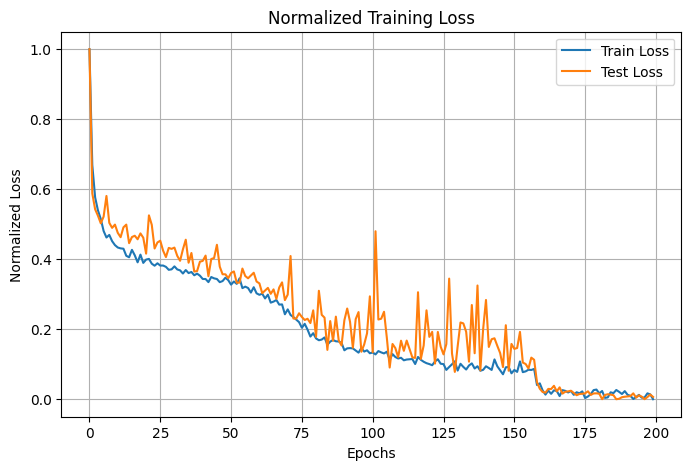

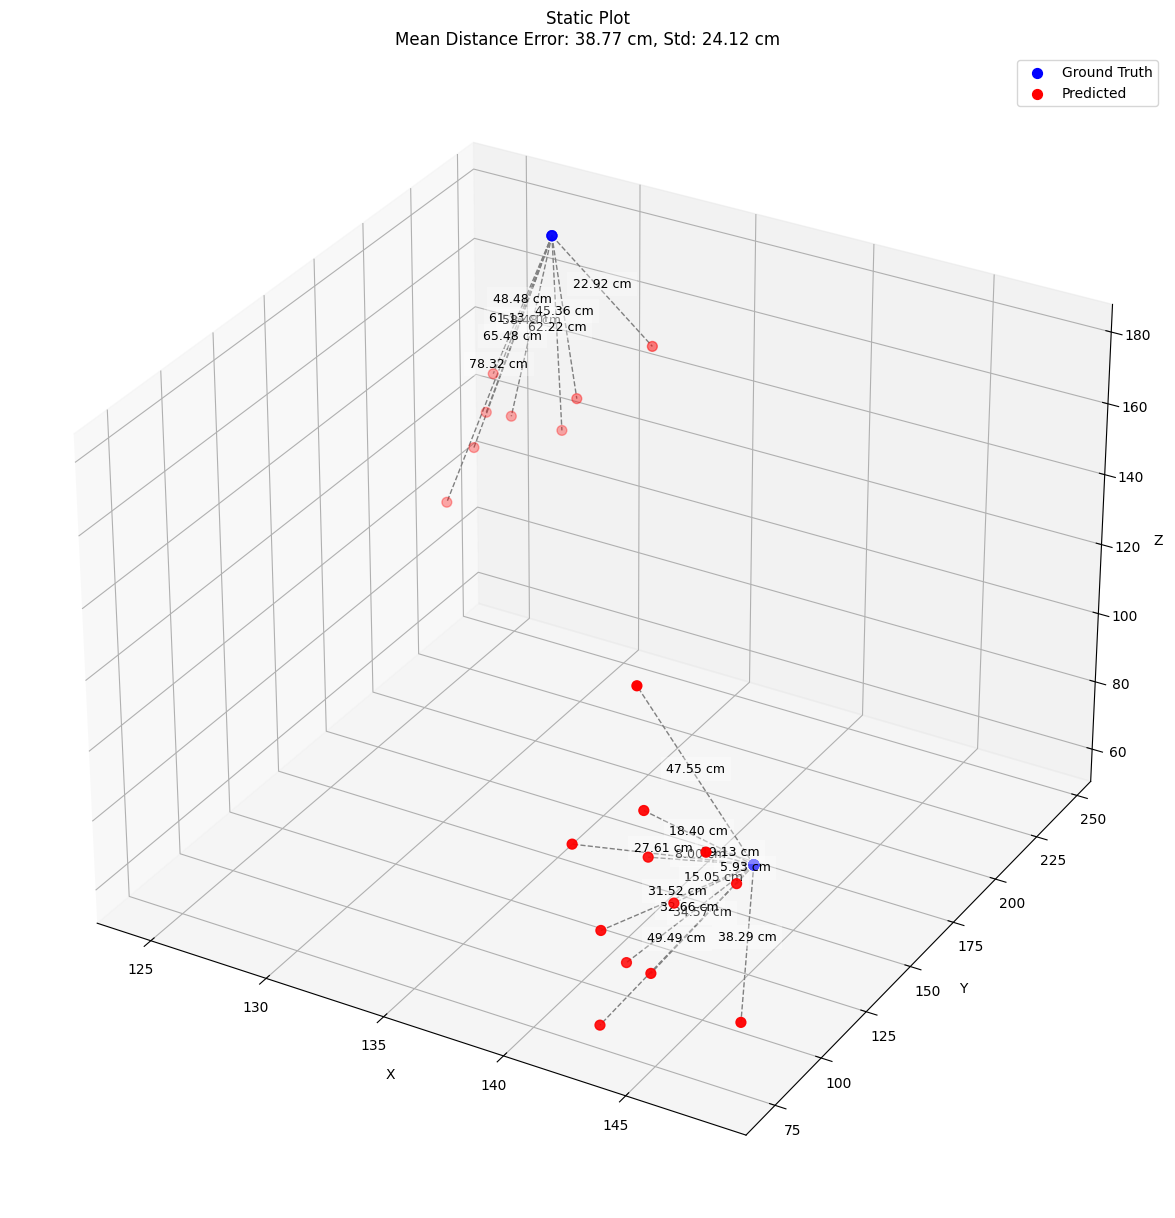

In [ ]:
# Instantiate the model
model_16 = CNN1DModel(input_channels=NUM_ANTENNAS*4, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-3


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_16.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr= 1e-5)
# Initialize early stopping
early_stopper = EarlyStopping(patience=100, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2, irrelevant_1, irrelevant_2 = train_test_model(epoch = 200,model = model_16, train_loader= train_loader_cnn, test_loader= test_loader_cnn, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True)

plot_results(arr1, arr2)

cnn_model = eval_model_3d_interactive(model_16, test_loader_cnn, scaler_rev_cnn, device)

## RNN

In [34]:
def data_func_cv_rnn(X_train_raw, X_test_raw, y_train, y_test, batch_size=32):
    # Compute abs max PER FEATURE on training data
     # Compute abs max PER FEATURE on training data
    for i in range(len(X_train_raw)):
        for j in range(X_train_raw.shape[2]):
            if (j+1)%4 == 0:
                X_train_raw[i, :,j] -= np.min(X_train_raw[i,:,j])        

    for i in range(len(X_test_raw)):
        for j in range(X_test_raw.shape[2]):
            if (j+1)%4 == 0:
                X_test_raw[i, :,j] -= np.min(X_test_raw[i,:,j])
    abs_max = np.abs(X_train_raw).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_train_raw / abs_max  
    X_test_norm = X_test_raw / abs_max  

    # Now reshape for linear model
    X_train_scaled = X_train_norm
    X_test_scaled = X_test_norm

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train)
    y_test_scaled = scaler_Y.transform(y_test)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y


In [35]:
def data_func_eval_rnn(X_main, X_holdout, y_main, y_holdout, batch_size = 32):
    # Compute abs max PER FEATURE on training data
     # Compute abs max PER FEATURE on training data
    for i in range(len(X_main)):
        for j in range(X_main.shape[2]):
            if (j+1)%4 == 0:
                X_main[i, :,j] -= np.min(X_main[i,:,j])        

    for i in range(len(X_holdout)):
        for j in range(X_holdout.shape[2]):
            if (j+1)%4 == 0:
                X_holdout[i, :,j] -= np.min(X_holdout[i,:,j])
    abs_max = np.abs(X_main).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_main / abs_max  # shape (N_train, 500, 4)
    X_test_norm = X_holdout / abs_max    # shape (N_test, 500, 4)

    # Now reshape for linear model
    X_train_scaled = X_train_norm
    X_test_scaled = X_test_norm

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_main_scaled = scaler_Y.fit_transform(y_main)
    y_holdout_scaled = scaler_Y.transform(y_holdout)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_main_tensor = torch.tensor(y_main_scaled, dtype=torch.float32)
    y_holdout_tensor = torch.tensor(y_holdout_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_main_tensor)
    test_data = TensorDataset(X_test_tensor, y_holdout_tensor)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

In [ ]:
def cross_validation_rnn(Main_Data, Holdout_Data, n_splits, model, model_param, loss_fn, optimizer_1, optimizer_param, scheduler_param, early_stopper_param, epochs, device, verbose = True):

    # Initialize KFold
    kf = KFold(n_splits= n_splits, shuffle= True, random_state= 42)

    # Initialize arrays to store losses and epochs
    cv_losses = []
    epoch_array = []

    # Loop over the folds to perform cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(range(len(Main_Data)))):
        
        print(f"Fold {fold_idx + 1}")

        train = [Main_Data[i] for i in train_idx]
        test = [Main_Data[i] for i in val_idx]
        
        all_permutations_train = []
        for sublist in train:
            sublist_permutations = list(permutations(sublist,NUM_ANTENNAS))
            all_permutations_train.append(sublist_permutations)

        train_data = []
        train_labels = []
        for perms in all_permutations_train:
            for perm in perms:
                connected_paths = []
                for i in range(len(perm)):
                    connected_paths.append(perm[i]['path'])
                if(connected_paths!=[]):
                    paths = np.hstack(connected_paths)
                    train_data.append(paths)
                    train_labels.append(perm[0]['tag_pos'])

        train_data = np.array(train_data)
        train_labels = np.array(train_labels)
        all_permutations_test = []
        for sublist in test:
            sublist_permutations = list(permutations(sublist,NUM_ANTENNAS))
            all_permutations_test.append(sublist_permutations)
        
        test_data = []
        test_labels = []
        for perms in all_permutations_test:
            for perm in perms:
                connected_paths = []
                for i in range(len(perm)):
                    connected_paths.append(perm[i]['path'])
                if(connected_paths!=[]):
                    paths = np.hstack(connected_paths)
                    test_data.append(paths)
                    test_labels.append(perm[0]['tag_pos'])

        test_data = np.array(test_data)
        test_labels = np.array(test_labels)

        train_loader, test_loader, _ = data_func_cv_rnn(train_data, test_data, train_labels, test_labels, batch_size=BATCH_SIZE)
        # Instantiate the model
        model_0 = model(**model_param)

        loss_fn = loss_fn
        optimizer = optimizer_1(model_0.parameters(), **optimizer_param)

        # Initialize the scheduler
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, **scheduler_param)

        # Initialize early stopping
        early_stopper = EarlyStopping(**early_stopper_param)

        # Load the data
        arr1, arr2, best_loss, epoch_stop = train_test_model(epoch = epochs,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True, verbose = verbose)
        
        if verbose == True:
            plot_results(arr1, arr2)

        cv_losses.append(best_loss)
        epoch_array.append(epoch_stop)
    

    all_permutations_main = []
    for sublist in Main_Data:
        sublist_permutations = list(permutations(sublist,NUM_ANTENNAS))
        all_permutations_main.append(sublist_permutations)
    
    main_data = []
    main_labels = []
    for perms in all_permutations_main:
        for perm in perms:
            connected_paths = []
            for i in range(len(perm)):
                connected_paths.append(perm[i]['path'])
            if(connected_paths!=[]):
                paths = np.hstack(connected_paths)
                main_data.append(paths)
                main_labels.append(perm[0]['tag_pos'])

    main_data = np.array(main_data)
    main_labels = np.array(main_labels)

    all_permutations_holdout = []
    for sublist in Holdout_Data:
        sublist_permutations = list(permutations(sublist,NUM_ANTENNAS))
        all_permutations_holdout.append(sublist_permutations)
    
    holdout_data = []
    holdout_labels = []
    for perms in all_permutations_holdout:
        for perm in perms:
            connected_paths = []
            for i in range(len(perm)):
                connected_paths.append(perm[i]['path'])
            if(connected_paths!=[]):
                paths = np.hstack(connected_paths)
                holdout_data.append(paths)
                holdout_labels.append(perm[0]['tag_pos'])
    
    holdout_data = np.array(holdout_data)
    holdout_labels = np.array(holdout_labels)

    # Evaluate the final model
    train_loader, test_loader, scaler_Y = data_func_eval_rnn(main_data, holdout_data, main_labels, holdout_labels, batch_size=BATCH_SIZE)
    print(f"Cross-Validation finished with mean error across {n_splits} subsets = {np.mean(cv_losses)}, evaluating final model...")

    # Instantiate the model
    final_model = model(**model_param)

    final_optimizer = optimizer_1(final_model.parameters(), **optimizer_param)

    # Initialize the scheduler
    scheduler = lr_scheduler.CosineAnnealingLR(final_optimizer, **scheduler_param)

    # Load the data
    arr1= train_test_model(epoch = np.max(epoch_array),model = final_model, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=final_optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= False, verbose= verbose)

    result = eval_model_3d_interactive(model= final_model, data_loader= test_loader, scaler= scaler_Y, verbose= True)
    return result

In [37]:
import torch.nn.functional as F

class EnhancedRNN(nn.Module):
    def __init__(self, input_size=8, hidden_size=16, num_layers=2, output_size=3, dropout=0.2):
        super().__init__()
        # LSTM with independent dropout masks for forward/backward passes
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0 if num_layers == 1 else dropout/2  # Halve dropout for bidir
        )
        
        # Improved normalization scheme
        self.ln1 = nn.LayerNorm(2*hidden_size)
        self.ln2 = nn.LayerNorm(4*hidden_size)
        
        # Revised FC architecture
        self.fc1 = nn.Linear(2*hidden_size, 4*hidden_size)
        self.fc2 = nn.Linear(4*hidden_size, 2*hidden_size)
        self.fc3 = nn.Linear(2*hidden_size, output_size)
        
        # Additional regularization
        self.dropout = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout/2)  # Smaller dropout for later layers
        
        self._init_weights()

    def _init_weights(self):
        # LSTM initialization
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
                # Set forget gate bias to 1 (improves LSTM performance)
                if 'bias_ih' in name or 'bias_hh' in name:
                    n = param.size(0)
                    param.data[n//4:n//2].fill_(1)
        
        # FC layer initialization
        for fc in [self.fc1, self.fc2, self.fc3]:
            nn.init.xavier_normal_(fc.weight)
            nn.init.constant_(fc.bias, 0.1)

    def forward(self, x):
        # LSTM with separate dropout for sequence and features
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        lstm_out = self.ln1(lstm_out)
        
        # Enhanced feature transformation
        out = F.selu(self.fc1(lstm_out))  # Self-normalizing activation
        out = self.dropout2(out)
        out = self.ln2(out)
        
        out = F.selu(self.fc2(out))
        out = self.dropout2(out)
        
        return self.fc3(out)

Fold 1


c:\Users\jimka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning:

The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.



Epoch 0 | Loss train: 1.316046 | Loss test: 0.762876 | lr = 4.3985622441392645e-05
Epoch 10 | Loss train: 0.898885 | Loss test: 0.695919 | lr = 0.00013987649885110177
Epoch 20 | Loss train: 0.757421 | Loss test: 0.669948 | lr = 0.0002888965449397013
Epoch 30 | Loss train: 0.683084 | Loss test: 0.632687 | lr = 0.00038096251713261124
Epoch 40 | Loss train: 0.628667 | Loss test: 0.582857 | lr = 0.00045166077033349664
Epoch 50 | Loss train: 0.595870 | Loss test: 0.579166 | lr = 0.0004949092777959133
Epoch 60 | Loss train: 0.559561 | Loss test: 0.553906 | lr = 0.0005428657644539055
Epoch 70 | Loss train: 0.519863 | Loss test: 0.510181 | lr = 0.000594875373011759
Epoch 80 | Loss train: 0.475712 | Loss test: 0.456466 | lr = 0.0006515077987516967
Epoch 90 | Loss train: 0.445154 | Loss test: 0.432488 | lr = 0.0006895600430947406
Epoch 100 | Loss train: 0.432862 | Loss test: 0.436120 | lr = 0.000704534077514917
Epoch 110 | Loss train: 0.422490 | Loss test: 0.444311 | lr = 0.0007170031407480712
E

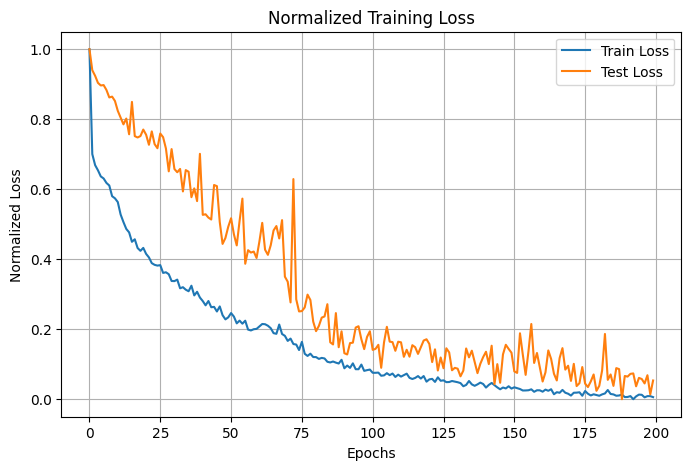

Fold 2


c:\Users\jimka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning:

The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.



Epoch 0 | Loss train: 1.256691 | Loss test: 0.731663 | lr = 2.13141315908358e-05
Epoch 10 | Loss train: 0.800850 | Loss test: 0.663965 | lr = 0.00023881747222202995
Epoch 20 | Loss train: 0.692935 | Loss test: 0.646560 | lr = 0.0003684017703920648
Epoch 30 | Loss train: 0.639548 | Loss test: 0.643921 | lr = 0.00043738555530509936
Epoch 40 | Loss train: 0.616368 | Loss test: 0.633670 | lr = 0.00046784821917652164
Epoch 50 | Loss train: 0.581115 | Loss test: 0.599761 | lr = 0.0005144117845059106
Epoch 60 | Loss train: 0.547920 | Loss test: 0.571667 | lr = 0.0005581872492830167
Epoch 70 | Loss train: 0.502777 | Loss test: 0.509078 | lr = 0.0006169835794562939
Epoch 80 | Loss train: 0.475408 | Loss test: 0.501799 | lr = 0.0006518913407405319
Epoch 90 | Loss train: 0.445828 | Loss test: 0.454392 | lr = 0.0006887333533738392
Epoch 100 | Loss train: 0.432261 | Loss test: 0.435008 | lr = 0.0007052616927897602
Epoch 110 | Loss train: 0.414757 | Loss test: 0.462067 | lr = 0.0007261944708268384
E

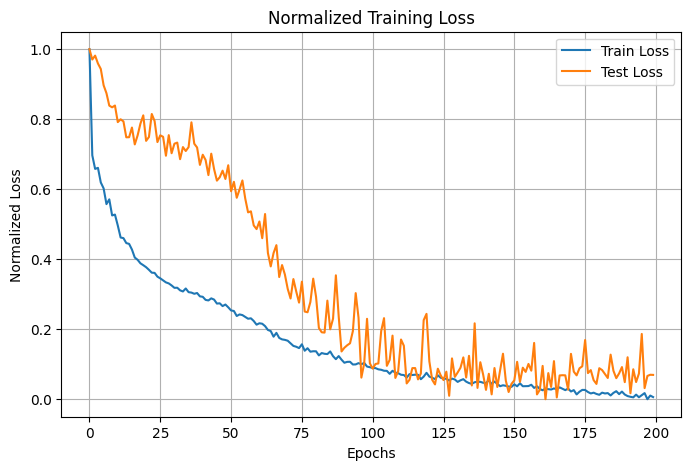

Cross-Validation finished with mean error across 2 subsets = 0.3945444245548809, evaluating final model...


c:\Users\jimka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning:

The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.



Epoch 0 | Loss train: 1.138502 | lr = 0.0009859830180795161
Epoch 10 | Loss train: 0.674530 | lr = 5.70811917209222e-05
Epoch 20 | Loss train: 0.661592 | lr = 4.3675656435079374e-05
Epoch 30 | Loss train: 0.655398 | lr = 3.802499952989447e-05
Epoch 40 | Loss train: 0.641911 | lr = 2.7474516085933884e-05
Epoch 50 | Loss train: 0.632828 | lr = 2.17451972284516e-05
Epoch 60 | Loss train: 0.622591 | lr = 1.6635891306652425e-05
Epoch 70 | Loss train: 0.613726 | lr = 1.337602299725013e-05
Epoch 80 | Loss train: 0.611153 | lr = 1.2633299322377962e-05
Epoch 90 | Loss train: 0.605871 | lr = 1.1397293470846599e-05
Epoch 100 | Loss train: 0.602523 | lr = 1.0814616618300923e-05
Epoch 110 | Loss train: 0.593403 | lr = 1.001984546583226e-05
Epoch 120 | Loss train: 0.591263 | lr = 1.0001430448786352e-05
Epoch 130 | Loss train: 0.582238 | lr = 1.0626626133389997e-05
Epoch 140 | Loss train: 0.578108 | lr = 1.1291278629401297e-05
Epoch 150 | Loss train: 0.568347 | lr = 1.3805120100847345e-05
Epoch 160 |

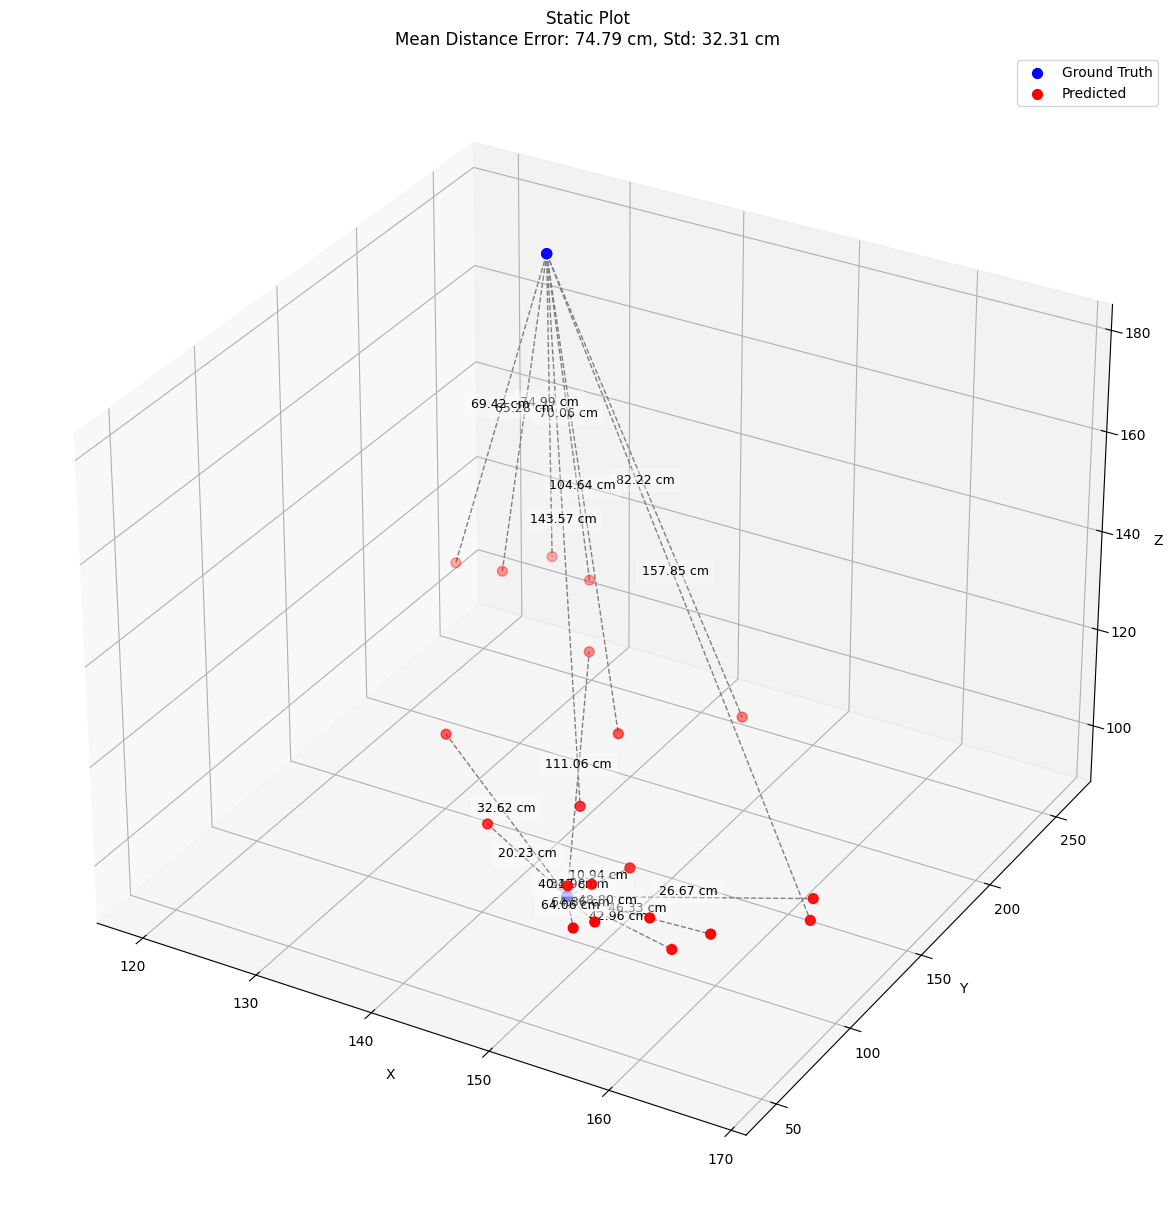

In [ ]:
loss_fn = nn.MSELoss()
#loss_fn = nn.SmoothL1Loss(beta=0.5)  # Better than Huber for this case
optim = torch.optim.Adam
optimizer_params = {
    'lr': 1e-3,
    'weight_decay': 1e-4,  # L2 regularization
    'amsgrad': True  # Adam variant
}
scheduler_params = {
    'T_max' : 100,
    'eta_min': 1e-5
}
model_params = {'input_size': NUM_ANTENNAS*4, 'output_size': output_len}
early_stop_params = {
    'patience': 120,  # Increased patience
    'min_delta': 1e-6,  # Smaller delta
    'verbose': False,
    'path':'temp_model.pth'
}
num_splits = 2
epoch = 200
BATCH_SIZE = 32

rnn = cross_validation_rnn(main_data, holdout_data, n_splits=num_splits, model= EnhancedRNN, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)